In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [49]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from IPython.display import display, HTML, Markdown
from scipy.sparse import csr
from scipy.sparse import csr_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Display centered pandas tables
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])
# Print in bold
def printmd(string):
    display(Markdown(string))

# Plot formats
from cycler import cycler
import matplotlib.patches as patches
import matplotlib.mlab as mlab
import matplotlib.dates
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# Set the randomizer seed so results are the same each time ... Reproducibility
np.random.seed(0)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\penpe\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## (1) 

For each of the first 5 training examples, print the text of the message along with the label.

In [4]:
def P1(num_examples=5):
    """ 
    1st Problem. Print the text of the message along with the label
    Args:
        Number of examples we want to run. Current default value num_examples = 5 (number of training examples)
    Returns:
        Text of the num_examples along with the label
    """
    printmd("**Number of training examples to print: %d**"%num_examples)
    for i in range(num_examples):
        printmd('**-**'*100+'\n')
        printmd('**Label of training example %d**'%(i+1))
        printmd('*%s*'%newsgroups_train.target_names[train_labels[i]]+'\n')
        printmd('**Text of the message in training example %d**'%(i+1))
        print("\n".join(train_data[i].split("\n")))
        printmd('**-**'*100+'\n')
    
P1()

**Number of training examples to print: 5**

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Label of training example 1**

*comp.graphics*


**Text of the message in training example 1**

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Label of training example 2**

*talk.religion.misc*


**Text of the message in training example 2**



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Label of training example 3**

*sci.space*


**Text of the message in training example 3**


 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) 

MB>                                                             So the
MB> 1970 figure seems unlikely to actually be anything but a perijove.

JG>Sorry, _perijoves_...I'm not used to talking this language.

Couldn't we just say periapsis or apoapsis?

 


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Label of training example 4**

*alt.atheism*


**Text of the message in training example 4**

I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, include within it
something simila

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Label of training example 5**

*sci.space*


**Text of the message in training example 5**

AW&ST  had a brief blurb on a Manned Lunar Exploration confernce
May 7th  at Crystal City Virginia, under the auspices of AIAA.

Does anyone know more about this?  How much, to attend????

Anyone want to go?


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


## (2) 
Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [5]:
def P2():
    """ 
    2nd Problem. Turn the raw data into features vectors using several steps
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a report with six outputs: 
            a.- Output of transforms in a sparse matrix
            b.- The 0th and Last feature string
            c.- Vocabulary with 4 words
            d.- Extraction of bigram and trigram character features
            e.- Pruned vocabulary (prune words that appear in fewer than 10 documents)
            f.- Compare the vocabulary from the dev set and the training set
    """
    # Part a - Transform to vector of features
    printmd('### Part a')
    printmd('**Description of the sparse matrix**\n')
    count_vector = CountVectorizer()
    train_data_count = count_vector.fit_transform(train_data)
    printmd("Dimensions of the sparse matrix is (%d,%d)"%train_data_count.shape)
    printmd('Number of examples is %d and the size of the vocabulary is %d'%(train_data_count.shape[0],\
                                                                              train_data_count.shape[1]))
    printmd('Average number of non-zero features per example is %.03f'%train_data_count.getnnz(axis=1).mean())
    total_elements = train_data_count.shape[0]*train_data_count.shape[1]
    printmd('Fraction of non-zeroes in the matriz is %.05f'%(train_data_count.nnz/total_elements))
    
    # Part b - 0th and Last feature
    printmd('### Part b')
    printmd('**The 0th and the last feature string**')
    names = count_vector.get_feature_names()
    printmd('The 0th string is *%s*'%names[0])
    printmd('The last string is *%s*'%names[-1])
    
    # Part c - Own Vocabulary with 4 words
    vocabulary = ["atheism", "graphics", "space", "religion"]
    own_count_vector = CountVectorizer(vocabulary=vocabulary)
    train_data_count_own = own_count_vector.fit_transform(train_data)
    printmd('### Part c')
    printmd('** Implement own vocabulary = ["atheism", "graphics", "space", "religion"] **')
    printmd('Check the dimensions of the sparse matrix (%d,%d)'%train_data_count_own.shape)
    printmd('Number of examples is %d and the size of the vocabulary is %d'%(train_data_count_own.shape[0],\
                                                                              train_data_count_own.shape[1]))
    printmd('Average number of non-zero features per example is %.03f'%train_data_count_own.getnnz(axis=1).mean())
    
    # Part d - Extract Bigrams and Trigrams
    ngram_count_vector = CountVectorizer(analyzer='char', ngram_range=(2,3))
    train_data_count_ngram = ngram_count_vector.fit_transform(train_data)
    printmd('### Part d')
    printmd('**Implement a n-gram vocabulary using bigram and trigrams**')
    printmd('Check the dimensions of the sparse matrix (%d,%d)'%train_data_count_ngram.shape)
    printmd('Number of examples is %d and the size of the vocabulary is %d'%(train_data_count_ngram.shape[0],\
                                                                              train_data_count_ngram.shape[1]))
    
    # Part e - Prune Words that appear in less than 10 documents
    prune_count_vector = CountVectorizer(min_df=10)
    train_data_count_prune = prune_count_vector.fit_transform(train_data)
    printmd('### Part e')
    printmd('**Implement a pruned vocabulary (prune words that appear in less than 10 documents)**')
    printmd('Check the dimensions of the sparse matrix (%d,%d)'%train_data_count_prune.shape)
    printmd('Number of examples is %d and the size of the vocabulary is %d'%(train_data_count_prune.shape[0],\
                                                                              train_data_count_prune.shape[1]))    
    
    # Part f - Using Standard Vocabulary, check fraction missing
    dev_count_vector = count_vector.fit_transform(dev_data)
    names_dev = count_vector.get_feature_names()
    printmd('### Part f')
    printmd('** Fraction of words in the dev set not in the Standard Vocabulary**')
    printmd('Fraction of words that are in the development set, but missing from the Standard Dictionary are \
             %.03f %%'%(100*(len(names_dev)-len(list(set(names).intersection(names_dev))))/len(names_dev)))
    
    
    
    
P2()

### Part a

**Description of the sparse matrix**


Dimensions of the sparse matrix is (2034,26879)

Number of examples is 2034 and the size of the vocabulary is 26879

Average number of non-zero features per example is 96.706

Fraction of non-zeroes in the matriz is 0.00360

### Part b

**The 0th and the last feature string**

The 0th string is *00*

The last string is *zyxel*

### Part c

** Implement own vocabulary = ["atheism", "graphics", "space", "religion"] **

Check the dimensions of the sparse matrix (2034,4)

Number of examples is 2034 and the size of the vocabulary is 4

Average number of non-zero features per example is 0.268

### Part d

**Implement a n-gram vocabulary using bigram and trigrams**

Check the dimensions of the sparse matrix (2034,35478)

Number of examples is 2034 and the size of the vocabulary is 35478

### Part e

**Implement a pruned vocabulary (prune words that appear in less than 10 documents)**

Check the dimensions of the sparse matrix (2034,3064)

Number of examples is 2034 and the size of the vocabulary is 3064

### Part f

** Fraction of words in the dev set not in the Standard Vocabulary**

Fraction of words that are in the development set, but missing from the Standard Dictionary are              24.788 %

## (3) 
Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using L2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

### Part a - kNN Neighbors Classifier

Optimal value for k is 150 with a F1 score of 45.08 %

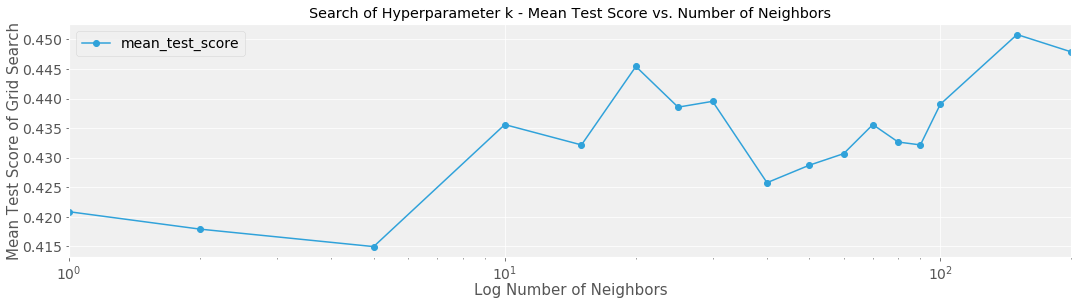

### Part b - Multinomial Naive Bayes

Optimal value for alpha is 0.0100 with a F1 score of 82.94 %

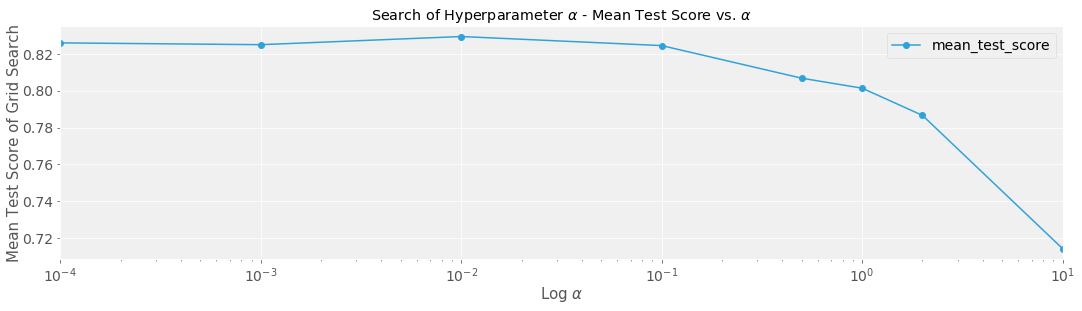

### Part c - Logistic Regression with L2 Regularization

Optimal value for C is 0.50 with a F1 score of 77.83 %

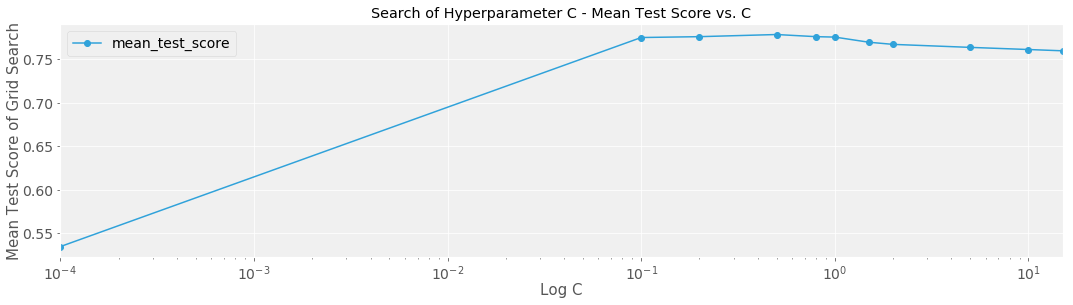

Relationship between sum of square weights values of each class anc C: 

- For **C=0.0001** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *0.01*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *0.01*

   ... 3\. *sci.space* - Sum of Squared Weights: *0.01*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *0.01*

- For **C=0.1000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *27.13*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *24.65*

   ... 3\. *sci.space* - Sum of Squared Weights: *27.46*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *23.03*

- For **C=0.2000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *49.75*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *42.75*

   ... 3\. *sci.space* - Sum of Squared Weights: *49.32*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *42.67*

- For **C=0.5000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *102.62*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *83.08*

   ... 3\. *sci.space* - Sum of Squared Weights: *99.04*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *88.98*

- For **C=0.8000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *143.58*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *113.58*

   ... 3\. *sci.space* - Sum of Squared Weights: *136.68*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *124.99*

- For **C=1.0000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *167.12*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *130.87*

   ... 3\. *sci.space* - Sum of Squared Weights: *157.95*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *145.73*

- For **C=1.5000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *216.60*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *167.48*

   ... 3\. *sci.space* - Sum of Squared Weights: *202.84*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *189.77*

- For **C=2.0000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *257.66*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *197.88*

   ... 3\. *sci.space* - Sum of Squared Weights: *239.93*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *226.61*

- For **C=5.0000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *422.76*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *322.90*

   ... 3\. *sci.space* - Sum of Squared Weights: *389.63*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *377.85*

- For **C=10.0000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *586.41*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *447.94*

   ... 3\. *sci.space* - Sum of Squared Weights: *539.09*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *530.68*

- For **C=15.0000** the sum of square weights values of each class is:

   ... 1\. *alt.atheism* - Sum of Squared Weights: *698.36*

   ... 2\. *comp.graphics* - Sum of Squared Weights: *536.29*

   ... 3\. *sci.space* - Sum of Squared Weights: *643.62*

   ... 4\. *talk.religion.misc* - Sum of Squared Weights: *637.90*

In [109]:
def P3():
    """ 
    3rd Problem. Using the default features vector, train a kNN, a Multinomial Naive Bayes, and a Logistic Regression
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a report with three outputs: 
            a.- F1 Score for the kNN classifier, after using GridSearch
            b.- F1 Score for the Multinomial Naive Bayes Classifier, after using GridSearch
            c.- F1 Score for Logistic Regression Classifier using L2 Regularization, using GridSearch
    """
    classes = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    mpl.rcParams['figure.figsize'] = 16,4
    fig = plt.figure(figsize=(16,4))
    
    # Part a - kNN Classifier
    knn_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', KNeighborsClassifier(n_jobs=-1)),
    ])
    k = [1,2,5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]
    param_grid = {
        'clf__n_neighbors': k}
    best_knn_clf = GridSearchCV(knn_clf,param_grid,cv = 5,scoring='f1_micro')
    best_knn_clf.fit(train_data, train_labels)
    results = pd.DataFrame(best_knn_clf.cv_results_,index = k)
    printmd('### Part a - kNN Neighbors Classifier')
    printmd('Optimal value for k is %d with a F1 score of %.02f %%'%(best_knn_clf.best_params_['clf__n_neighbors'],\
                                                                 100*best_knn_clf.best_score_))
    ax = results.plot('param_clf__n_neighbors','mean_test_score', linestyle='-', marker='o', logx=True)
    ax.set_title("Search of Hyperparameter k - Mean Test Score vs. Number of Neighbors")
    ax.set_xlabel('Log Number of Neighbors')
    ax.set_ylabel('Mean Test Score of Grid Search')
    plt.show()

    
    # Part b - Multinomial Naive Bayes
    nb_multi_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', MultinomialNB()),
    ])
    alpha = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    param_grid = {
        'clf__alpha': alpha}
    best_nb_multi_clf = GridSearchCV(nb_multi_clf,param_grid,cv = 5,scoring='f1_micro')
    best_nb_multi_clf.fit(train_data, train_labels)
    results = pd.DataFrame(best_nb_multi_clf.cv_results_,index = alpha)
    printmd('### Part b - Multinomial Naive Bayes')
    printmd('Optimal value for alpha is %.04f with a F1 score of %.02f %%'%(best_nb_multi_clf.best_params_['clf__alpha'],\
                                                                 100*best_nb_multi_clf.best_score_))
    fig = plt.figure(figsize=(16,4))
    ax = results.plot('param_clf__alpha','mean_test_score', linestyle='-', marker='o', logx=True)
    ax.set_title("Search of Hyperparameter $\\alpha$ - Mean Test Score vs. $\\alpha$")
    ax.set_xlabel('Log $\\alpha$')
    ax.set_ylabel('Mean Test Score of Grid Search')
    plt.show()

    
    # Part c - Logistic Regression with L2 Regularization
    log_reg_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', LogisticRegression(penalty='l2', n_jobs=-1)),
    ])
    C = [0.0001, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2.0, 5.0, 10.0, 15.0]
    param_grid = {
        'clf__C': C}
    best_log_reg_clf = GridSearchCV(log_reg_clf,param_grid,cv = 5,scoring='f1_micro')
    best_log_reg_clf.fit(train_data, train_labels)
    results = pd.DataFrame(best_log_reg_clf.cv_results_,index = C)
    printmd('### Part c - Logistic Regression with L2 Regularization')
    printmd('Optimal value for C is %.02f with a F1 score of %.02f %%'%(best_log_reg_clf.best_params_['clf__C'],\
                                                                 100*best_log_reg_clf.best_score_))
    fig = plt.figure(figsize=(16,4))
    ax = results.plot('param_clf__C','mean_test_score', linestyle='-', marker='o', logx=True)
    ax.set_title("Search of Hyperparameter C - Mean Test Score vs. C")
    ax.set_xlabel('Log C')
    ax.set_ylabel('Mean Test Score of Grid Search')
    plt.show()
    printmd('Relationship between sum of square weights values of each class anc C: ')
    for c in C:
        log_reg_clf = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', LogisticRegression(penalty='l2', C=c, n_jobs=-1)),
        ])
        log_reg_clf.fit(train_data, train_labels)
        printmd('- For **C=%.04f** the sum of square weights values of each class is:'%c)
        
        for i, weight in enumerate(classes):
            printmd('   ... %s\. *%s* - Sum of Squared Weights: *%.02f*'%(i+1,weight,\
                                                                 np.sum(log_reg_clf.named_steps['clf'].coef_[i]**2)))
        

a = P3()

### Answer:

a. kNN doesn't work well in this problem because it needs to have a large dataset to be effective: in our case we are working with only 2034 examples. Therefore, it needs many neighbors to be effective, and is not finding out the real division of the hyperspace because of lack of training data. Also, the way distances work in the space is not well suited: how 'far' a word is from another is not well defined, because we are not normalizing the way we process the frequency count.

b. Because the data fits a Naive Bayes Multinomial quite well: events are almost idenpendent, training data is small, and is possible the events comes from a non-linear data generative model, which means logistic regression will present some problems. However, the greater the amount of training data, logistic regression should perfom better

c. Is obvious that the higher the value of C, the sum square weights of each class will increase. C is the inverse of the regularization parameter, therefore, the lower its value, the more penalized each weight are. When C increases, the weights increases with it. Because we are using a L2 regularization, this relationship is valid in the sum square space. Also, we can see that the the F1 score is flat around 0.1 to 0.5. The smaller the value of C, the weights become relatively smaller. For P4 I'll compromise and use a value of 0.25

## (4) 
Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [41]:
def P4():
    """ 
    4th Problem. Using the default features vector, train a Logistic Regression, using the C from P3. 
    Args:
        No arguments. All data is loaded in the global environment.
    Returns:
        The function will return a report with two outputs: 
            a.- Table with 20 rows and 4 columns of the weights of each feature using standard Vocabularory
            b.- Similar table using bigram features instead
    """   
    
    # Part a - Standard Vocabulary. Optimal C=0.25
    classes = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    log_reg_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', LogisticRegression(penalty='l2', C=0.25, n_jobs=-1)),
    ])
    log_reg_clf.fit(train_data, train_labels)
    top_5_indices = np.fliplr(log_reg_clf.named_steps['clf'].coef_.argsort()[:,-5:]).flatten()
    features = np.array(log_reg_clf.named_steps['vect'].get_feature_names())[top_5_indices]
    weights = log_reg_clf.named_steps['clf'].coef_[:,top_5_indices].T
    table_feat_weight = pd.DataFrame(weights, index=features, columns = classes)
    printmd('### Part a - Logistic Regression - Word Vocabulary C = 0.25')
    printmd('*Table of the top 5 features by weights per label*')
    display(table_feat_weight.round(4).style.background_gradient(cmap='gist_gray'))
    
    # Part b - Bigram Vocabulary. Optimal C=0.25
    classes = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    log_reg_clf_bi = Pipeline([
        ('vect', CountVectorizer(analyzer='word', ngram_range=(2,2))),
        ('clf', LogisticRegression(penalty='l2', C=0.25, n_jobs=-1)),
    ])
    log_reg_clf_bi.fit(train_data, train_labels)
    top_5_indices_bi = np.fliplr(log_reg_clf_bi.named_steps['clf'].coef_.argsort()[:,-5:]).flatten()
    features_bi = np.array(log_reg_clf_bi.named_steps['vect'].get_feature_names())[top_5_indices_bi]
    weights_bi = log_reg_clf_bi.named_steps['clf'].coef_[:,top_5_indices_bi].T
    table_feat_weight_bi = pd.DataFrame(weights_bi, index=features_bi, columns = classes)
    printmd('### Part b - Logistic Regression - BiWord Vocabulary C = 0.25')
    printmd('*Table of the top 5 features by weights per label*')
    display_df = table_feat_weight_bi.reset_index()
    display(display_df.round(4).style.background_gradient(cmap='gist_gray'))

P4()

### Part a - Logistic Regression - Word Vocabulary C = 0.25

*Table of the top 5 features by weights per label*

,alt.atheism,comp.graphics,sci.space,talk.religion.misc
bobby,0.6674,-0.1608,-0.233,-0.3152
atheists,0.6578,-0.0889,-0.2178,-0.4682
atheism,0.6576,-0.2877,-0.2898,-0.3274
religion,0.6575,-0.4103,-0.5368,-0.0278
islam,0.5627,-0.0963,-0.2298,-0.2322
graphics,-0.535,1.3409,-0.8919,-0.5064
image,-0.3705,0.8997,-0.5303,-0.3031
file,-0.2274,0.8667,-0.5651,-0.4027
3d,-0.249,0.7653,-0.4505,-0.2569
computer,0.0109,0.7186,-0.4606,-0.3169


### Part b - Logistic Regression - BiWord Vocabulary C = 0.25

*Table of the top 5 features by weights per label*

,index,alt.atheism,comp.graphics,sci.space,talk.religion.misc
0,cheers kent,0.4526,-0.5413,-0.521,0.4533
1,claim that,0.4499,-0.1511,-0.209,-0.0958
2,in this,0.3828,-0.0024,-0.3971,-0.093
3,you are,0.3767,-0.2412,-0.3951,0.0497
4,are you,0.3735,-0.2005,-0.0878,-0.2322
5,looking for,-0.5173,0.9089,-0.402,-0.4586
6,in advance,-0.3799,0.696,-0.3552,-0.339
7,out there,-0.2295,0.6262,-0.3864,-0.2257
8,is there,-0.2637,0.6009,-0.3785,-0.1898
9,comp graphics,-0.2226,0.595,-0.2898,-0.2028


### Answer:

Is quite surprising that when we increase the vocubaluray to bigram words, we start 'losing' some of the interpretability of the model. For a 1-word model, for each label, the most important features seem to be related to the space: religion, islam for atheism; graphics, image for comp.graphics; etc. However, when we increase to 2-Word models, the most important features start to be common combinations of words in the English language: 'with you', 'you are', 'are you', etc. Although there are combinations that seems quite on the spot like 'the moon' or 'sci space', the model start showing one of the main issues of text classification: how to model the English Language and all the possible combinations that happens naturally just because, the so called 'Stop Words' start to appear more often because of these combinations.

## (5) 
Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [56]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    """
    Function for preprocessing the string data for better classification
    Args:
        String
    Returns:
        Processed String
    """
    # Let's start by lowering everything and doing Regex (non-letter, extra spaces, plural, numbers)
    s = s.lower()
    s_new = re.sub(r"[,@\'?\.$%_]", "", s, flags=re.I) 
    s_new = re.sub(r"\s+"," ", s_new, flags = re.I)  
    s_new = re.sub(r'ies\b|es\b|s\b|y\b', '', s_new, flags=re.I)
    s_new = re.sub(r'\w*\d\w*|_', '', s_new).strip()
    
    # Now, let's use NLP for removing Stop Words and tokenize
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(s_new) 
    filtered_s = [w for w in word_tokens if not w in stop_words] 
    filtered_s = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_s.append(w) 
    return str(filtered_s)

def P5():
    """ 
    5th Problem. Comparing empty preprocessor with custom preprocessor to improve training and reduce the size of vocabulary
    Args:
        No arguments. All data is loaded in the global environment. C used equal to 0.25 as before
    Returns:
        The function will return a report of the difference of sizes of the vocabularies and the F1 scores
    """   
    # Part a - Empty Preprocessor
    log_reg_clf_emp = Pipeline([
        ('vect', CountVectorizer(preprocessor=empty_preprocessor)),
        ('clf', LogisticRegression(penalty='l2', C=0.25, n_jobs=-1)),
    ])
    log_reg_clf_emp.fit(train_data, train_labels)
    printmd('## Training with Train Data, Evaluating Performance in Dev Data')
    printmd('### Part a - Empty Preprocessor')
    voc_emp = log_reg_clf_emp.named_steps['clf'].coef_.shape[1]
    y_dev_pre_emp = log_reg_clf_emp.predict(dev_data)
    f1_emp = metrics.f1_score(dev_labels, y_dev_pre_emp,average='micro')
    printmd('The size of the vocabulary is %d and the F1 score is %.03f'%(voc_emp, f1_emp))
    
    # Part b - Custom Preprocessor
    log_reg_clf_cst = Pipeline([
        ('vect', CountVectorizer(preprocessor=better_preprocessor)),
        ('clf', LogisticRegression(penalty='l2', C=0.25, n_jobs=-1)),
    ])
    log_reg_clf_cst.fit(train_data, train_labels)
    printmd('### Part b - Custom Preprocessor')
    voc_cst = log_reg_clf_cst.named_steps['clf'].coef_.shape[1]
    y_dev_pre_cst = log_reg_clf_cst.predict(dev_data)
    f1_cst = metrics.f1_score(dev_labels, y_dev_pre_cst,average='micro')
    printmd('The size of the vocabulary is %d and the F1 score is %.03f'%(voc_cst, f1_cst))
    printmd('*The preprocessor reduced the vocabulary by %d and increased(decrease) the F1 score by %.04f*'%(voc_emp-\
                                                                                                voc_cst,f1_cst-f1_emp))
    
P5()

## Training with Train Data, Evaluating Performance in Dev Data

### Part a - Empty Preprocessor

The size of the vocabulary is 33291 and the F1 score is 0.710

### Part b - Custom Preprocessor

The size of the vocabulary is 21750 and the F1 score is 0.714

*Difference in words is 11541 and the increase(decrease) in F1 score is 0.0044*

## (6) 
The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

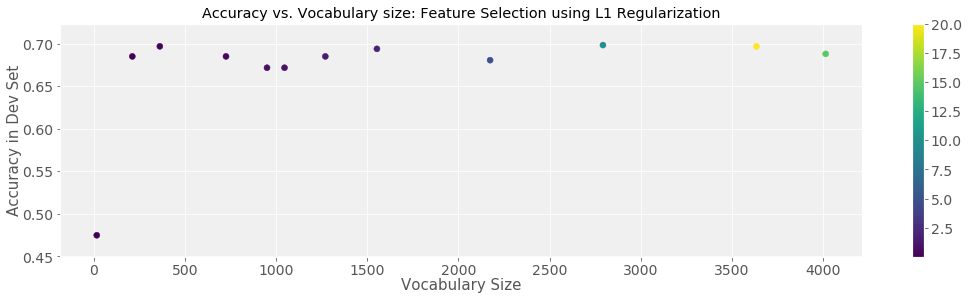

In [69]:
def P6():
    """ 
    6th Problem. Use L1 Regularization for feature selection
    Args:
        No arguments. All data is loaded in the global environment. C will be the same for both models
    Returns:
        Plot of the size of the vocabulary vs. the accuracy of the model. 
    """   
    # Parameters of the iteration and Gradient Descent
    np.random.seed(0)
    C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0]
    tol = 0.01
    size_voc = []
    acc = []
    for c in C:
        # L1 Regularization for feature selection
        log_reg_clf_l1 = Pipeline([
            ('vect', CountVectorizer()),
            ('clf', LogisticRegression(penalty='l1', C=c, n_jobs=-1, tol=0.01)),
        ])
        log_reg_clf_l1.fit(train_data, train_labels)
        log_reg_clf_l1_coef = np.sum(log_reg_clf_l1.named_steps['clf'].coef_,axis=0).nonzero()
        log_reg_clf_l1_vocab = log_reg_clf_l1.named_steps['vect'].get_feature_names()
        l1_features = np.array(log_reg_clf_l1_vocab)[log_reg_clf_l1_coef]
        
        # L2 Regularization for Training
        log_reg_clf_l2 = Pipeline([
            ('vect', CountVectorizer(vocabulary=l1_features)),
            ('clf', LogisticRegression(penalty='l2', C=c, n_jobs=-1, tol=0.01)),
        ])
        log_reg_clf_l2.fit(train_data, train_labels)
        size_voc.append(log_reg_clf_l2.named_steps['clf'].coef_.shape[1])
        y_dev_pre_cst = log_reg_clf_l2.predict(dev_data)
        acc.append(metrics.accuracy_score(dev_labels, y_dev_pre_cst))
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(16,4))
    cmap = matplotlib.cm.get_cmap('viridis')
    normalize = matplotlib.colors.Normalize(vmin=min(C), vmax=max(C))
    colors = [cmap(normalize(value)) for value in C]
    ax.scatter(size_voc, acc, marker='o', color=colors)
    ax.set_title('Accuracy vs. Vocabulary size: Feature Selection using L1 Regularization')
    ax.set_xlabel('Vocabulary Size')
    ax.set_ylabel('Accuracy in Dev Set')
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
    plt.show()
    
    

P6()

### Answer

It's quite clear how L1 regularization shrinks the vocabulary size in quite a spectacular way. This is a strategy also use in LASSO regression, where we do feature selection first by using L1 norm. The reasoning behind it is that L1 ignores any kind of outliers of the data, and tends to the median, instead of the mean. Thus, the weights are 'solved' to zero quickly by the linear programming. On the other hand, L2 norm tends to the average, thus outliers have a huge impact on it. The way L2 handles it is to have almost all the weigths with at least some value.

## (7)
Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

**Documents with largest R ratio**

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 273.82**

**Label of development example 1 and label predicted**

*talk.religion.misc - comp.graphics*


**Text of the message in training example 1**

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 639.31**

**Label of development example 2 and label predicted**

*alt.atheism - talk.religion.misc*


**Text of the message in training example 2**


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 1552.17**

**Label of development example 3 and label predicted**

*talk.religion.misc - comp.graphics*


**Text of the message in training example 3**

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
for the precise terms.

Negotiat

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


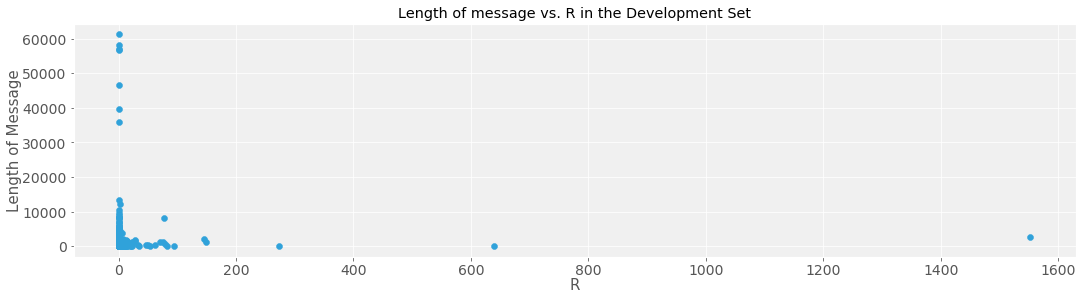

In [113]:
def P7():
    """ 
    7th Problem. Introduce TdifVectorizer to the Pipeline
    Args:
        No arguments. All data is loaded in the global environment. C=100
    Returns:
        Report the 3 documents with the highest R ratio  
    """ 
    # Train the classifier
    classes = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    log_reg_clf_final = Pipeline([
        ('vect', CountVectorizer(preprocessor=better_preprocessor)),
        ('tdif',TfidfTransformer()),
        ('clf', LogisticRegression(penalty='l2', C=100, n_jobs=-1)),
    ])
    log_reg_clf_final.fit(train_data, train_labels)
    y_dev_pre_final = log_reg_clf_final.predict(dev_data)
    prob = log_reg_clf_final.predict_proba(dev_data)
    correct_label_prob = np.zeros(676)
    for i in range(dev_labels.shape[0]):
        correct_label_prob[i] = prob[i,dev_labels[i]]
    R = np.max(prob, axis=1)/correct_label_prob
    max_R_index = R.argsort()[-3:]
    printmd("**Documents with largest R ratio**")
    j = 1
    for i in max_R_index:
        printmd('**-**'*100+'\n')
        printmd('**Value or R is %.2f**'%R[i])
        printmd('**Label of development example %d and label predicted**'%(j))
        target_name = classes [y_dev_pre_final[i]]
        printmd('*%s - %s*'%(newsgroups_test.target_names[dev_labels[i]],target_name)+'\n')
        printmd('**Text of the message in training example %d**'%(j))
        print("\n".join(dev_data[i].split("\n")))
        printmd('**-**'*100+'\n')
        j += 1
        
    # Plot the length of each message vs. R
    len_s = [len(s) for s in dev_data]
    fig, ax = plt.subplots(figsize=(16,4))
    ax.scatter(R, len_s, marker='o')
    ax.set_title('Length of message vs. R in the Development Set')
    ax.set_xlabel('R')
    ax.set_ylabel('Length of Message')
    plt.show()
    
P7()

### Answer:

For these three messages we can infer why the classifier had problems: for the first and last, the message encoded was describing how to get a certain book online, with a quite specific description on how to download it, formats, etc. These words match with the vocabulary of the label predicted more than the actual label, thus the problem. For the second message, it appears it's quite short and there is something that's confusing the classifier. 

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies

## (8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [136]:
def P8():
    """ 
    8th Problem. Improve the accuracy of logistic regression
    Args:
        All data is loaded in the global environment. From P6, I'll use C=20
    Returns:
        Prints in console accuracy of improvement
    """  
    # Selection of features using L1 Regularization and TDIf
    classes = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    log_reg_clf_l1 = Pipeline([
        ('vect', CountVectorizer(preprocessor=better_preprocessor, min_df=2, max_df=0.12, stop_words='english')),
        ('tdif', TfidfTransformer(norm='l1')),
        ('clf', LogisticRegression(penalty='l1', C=20, n_jobs=-1, tol=0.001)),
    ])
    log_reg_clf_l1.fit(train_data, train_labels)
    log_reg_clf_l1_coef = np.sum(log_reg_clf_l1.named_steps['clf'].coef_,axis=0).nonzero()
    log_reg_clf_l1_vocab = log_reg_clf_l1.named_steps['vect'].get_feature_names()
    l1_features = np.array(log_reg_clf_l1_vocab)[log_reg_clf_l1_coef]
    
    # Train using L2 and vocabulary
    log_reg_clf_l2 = Pipeline([
        ('vect', CountVectorizer(preprocessor=better_preprocessor, vocabulary=l1_features,\
                                 min_df=2, max_df=0.2, stop_words='english')),
        ('tdif', TfidfTransformer()),
        ('clf', LogisticRegression(penalty='l2', C=20, n_jobs=-1, tol=0.001)),
    ])
    log_reg_clf_l2.fit(train_data, train_labels)
    y_dev_pre = log_reg_clf_l2.predict(dev_data)
    printmd('### Part a - Improvement in Accuracy')
    printmd('New accuracy of this model is %.03f'%metrics.accuracy_score(dev_labels, y_dev_pre))
    prob = log_reg_clf_l2.predict_proba(dev_data)
    correct_label_prob = np.zeros(676)
    for i in range(dev_labels.shape[0]):
        correct_label_prob[i] = prob[i,dev_labels[i]]
    R = np.max(prob, axis=1)/correct_label_prob
    max_R_index = R.argsort()[-3:]
    printmd('### Part b - Examples of misslabeling')
    printmd("**Documents with largest R ratio in new model**")
    j = 1
    for i in max_R_index:
        printmd('**-**'*100+'\n')
        printmd('**Value or R is %.2f**'%R[i])
        printmd('**Label of development example %d and label predicted**'%(j))
        target_name = classes [y_dev_pre[i]]
        printmd('*%s - %s*'%(newsgroups_test.target_names[dev_labels[i]],target_name)+'\n')
        printmd('**Text of the message in training example %d**'%(j))
        print("\n".join(dev_data[i].split("\n")))
        printmd('**-**'*100+'\n')
        j += 1
        
P8()

### Part a - Improvement in Accuracy

New accuracy of this model is 0.740

### Part b - Examples of misslabeling

**Documents with largest R ratio in new model**

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 520.37**

**Label of development example 1 and label predicted**

*alt.atheism - comp.graphics*


**Text of the message in training example 1**


The CLIPPER initiative is an announcement by Clinton that all the 
"secure" voice phones will use the same crypto chip, as a de-facto
government standard.  Problem is, the government is admitting that
they hold the keys to break the code easily, and the Justice department
will be using the keys to listen in on "illegal activities."  Many
people are really scared about such an initiative because it is
a major step towards outlawing real crypto protection on things
like email if you read the press release.  The project was developed
by NSA and given to NIST.  It uses two keys S1 and S2 that the
government claims are needed to break the code.  They claim that
these keys will be handed to two different companies, and when they
get a warrant to do a wiretap (the chip is nicknamed the wiretap chip),
they have to get the keys from both companies.  People have poked holes
through and through the press release official version and shown how
it is nowhere near as nice as it sounds, and I have g

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 783.16**

**Label of development example 2 and label predicted**

*talk.religion.misc - comp.graphics*


**Text of the message in training example 2**

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book itself
for the precise terms.

Negotiat

**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


**Value or R is 1135.22**

**Label of development example 3 and label predicted**

*alt.atheism - talk.religion.misc*


**Text of the message in training example 3**


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



**-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-****-**


### Answer:

With an ensemble tactic we are able to improve our accuracy by 4%, all next work should be focus on preprocessing the data and creating dictionaries for each label, to improve the vocabularies (done here using L1 regularization)

Also, although we have two similar occurrances of mislabel as before, all three mislabels can be attributed to the similarity of the languages and the vocabularies of the training. With more data, we can improve our performance by improving the corpus of each label